# Defining a new LCA - power series calculations

We can approximate the solution our technosphere system as: 

$$(I - A)^{-1}f \approx If + \sum_{i} A^{i}f$$ 

Where *i* is suitably large number, perhaps 10 or 20. Basically, each time you raise **A** to another power, you go one more level deep in the supply chain. The power series expansion is only an exact solution when *i* goes to infinity. This is actually quite easy to understand; here are some citations:

* [Power series expansion and structural analysis for life cycle assessment](http://link.springer.com/article/10.1065%2Flca2007.08.360)
* [Efficient algorithms for Life Cycle Assessment, Input-Output Analysis, and Monte-Carlo Analysis](http://link.springer.com/article/10.1065%2Flca2006.06.254)

To write an LCA that uses power series expansion, we first need to handle the fact that our technosphere matrix **A** is actually already (**I** - **A**). However, this is easy to fix, as:

$$A = I - (I - A)$$

In this code, we check that each dataset is already scaled to produce one unit of output, i.e. the diagonal of **A** is filled only with ones.

In [1]:
from brightway2 import *

In [2]:
if "BW2 introduction" not in projects:
        raise ValueError("Must have run introductory notebook already!")

projects.current = "BW2 introduction"

In [3]:
from scipy import sparse
import numpy as np

In [4]:
class PowerSeriesLCA(LCA):
    def solve_linear_system(self, iterations=20):
        count = self.technosphere_matrix.shape[0]
        self.ps_technosphere = sparse.identity(count) - self.technosphere_matrix
        self.ps_current = sparse.identity(count)
        self.ps_exponent = 0
        self.supply_array = self.ps_current * self.demand_array
        while self.ps_exponent < iterations:
            self.power_series_iteration()
        return self.supply_array

    def rescale(self):
        for x in range(self.technosphere_matrix.shape[0]):
            if self.technosphere_matrix[x, x] != 1:
                self.technosphere_matrix[x, :] *= 1 / self.technosphere_matrix[x, x]
        
    def power_series_iteration(self):
        self.ps_current = self.ps_current * self.ps_technosphere
        # Drop NaN and small values to avoid floating point errors 
        nan_mask = np.isnan(self.ps_current.data)
        too_small_mask = self.ps_current.data < 1e-100
        self.ps_current.data[nan_mask + too_small_mask] = 0
        self.supply_array += self.ps_current * self.demand_array
        self.ps_exponent += 1

    def calculate_inventory(self):
        count = self.technosphere_matrix.shape[0]
        self.inventory = self.biosphere_matrix * \
            sparse.spdiags([self.supply_array], [0], count, count)

    def lci(self):
        """Instead of doing ``.lci()``, we will need to do the following:
    
        .lci()  # Loads data, builds demand array
        .solve_linear_system(iterations)
        .calculate_inventory()
    
        """
        self.load_lci_data()
        self.build_demand_array() 
        self.rescale()

In [5]:
functional_unit = {Database("forwast").random(): 1}
method = methods.random()
functional_unit, method

({'_71 Motor vehicles and trailers, EU27' (EUR2003, GLO, ['Input Output', 'EU27 2003']): 1},
 ('ReCiPe Midpoint (E)', 'particulate matter formation', 'PMFP'))

In [6]:
ps = PowerSeriesLCA(functional_unit, method)
ps.lci()
# Score up to 5 supply chain levels
ps.solve_linear_system(5)
ps.calculate_inventory()
ps.lcia()
ps.score

0.0005258338313922619

One of the strengths of Brightway2 is scripting common tasks, and doing many calculations quickly. Let's first define a function that gives us the total LCA score at each power series step:

In [7]:
def calculate_convergence(lca, max_iterations=100):
    """Keep total score after each power series step, to calculate how fast it converges"""
    results = []
    lca.lci()
    lca.solve_linear_system(1)
    lca.calculate_inventory()
    lca.lcia()
    results.append(lca.score)

    for iteration in range(1, max_iterations):
        lca.power_series_iteration()
        lca.calculate_inventory()
        lca.lcia_calculation()
        results.append(lca.score)

    # Return LCA scores for `max_iterations` levels
    return results

And then chart how fast the score converges to the total score for funcitonal unit and method. Note that this graph is log-scaled on the x axis.

In [8]:
%matplotlib inline

In [9]:
import matplotlib.pyplot as plt

In [10]:
ys = calculate_convergence(PowerSeriesLCA(functional_unit, method), 100)
xs = range(1, len(ys) + 1)

In [11]:
lca = LCA(functional_unit, method)
lca.lci()
lca.lcia()

(0, 0.00060000000000000006)

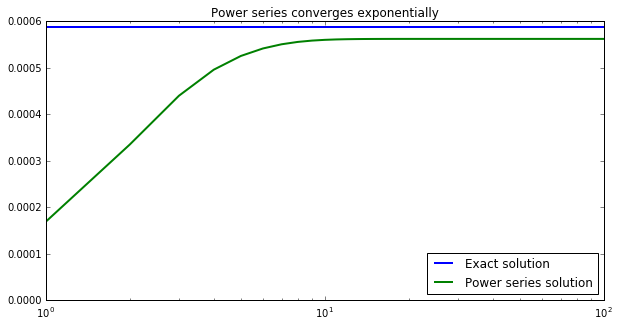

In [12]:
fig = plt.gcf()
fig.set_size_inches(10, 5)

plt.plot([min(xs), max(xs)], [lca.score, lca.score], lw=2, label="Exact solution")
plt.semilogx(xs, ys, lw=2, label="Power series solution")
plt.title("Power series converges exponentially")
plt.legend(loc="lower right")
plt.ylim(0, plt.ylim()[1])

If we are going to analyze many LCI datasets, we need to normalize the scores to sum to one. We also need to skip "dummy" processes where the total score is 0.

In [13]:
def check_convergence_real_score(key):
    functional_unit = {key: 1}
    lca = LCA(functional_unit, method)
    lca.lci()
    lca.lcia()
    if not lca.score > 0: 
        return None
    else:
        return np.array(calculate_convergence(PowerSeriesLCA(functional_unit, method), 100)) / lca.score

Calculate convergence for each process in the US LCI database.

In [14]:
import multiprocessing

pool = multiprocessing.Pool(processes=multiprocessing.cpu_count())
jobs = pool.map(check_convergence_real_score, [x.key for x in Database("forwast")])
pool.close()
pool.join()

In [15]:
results = [o for o in jobs if o is not None]

Number of valid results to plot

In [16]:
len(results)

239

(0, 1.1)

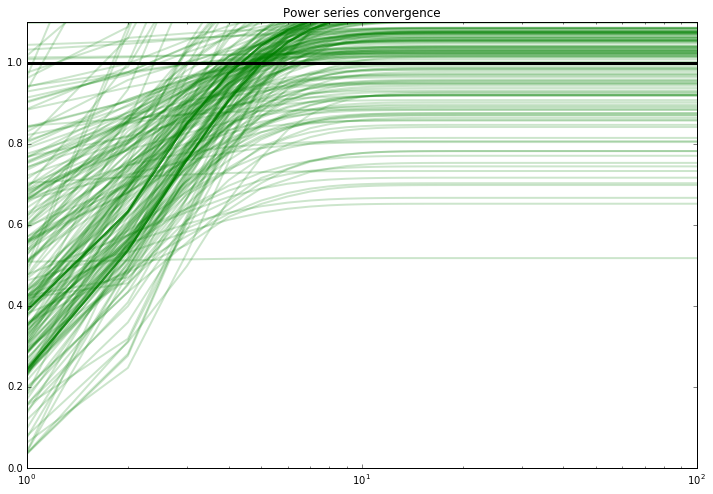

In [19]:
fig = plt.gcf()
fig.set_size_inches(12, 8)

for ds in results:
    if np.nanmin(ds) < 0:
        continue
    #elif np.nanmax(ds) > 1:
    #    continue
    plt.semilogx(range(1, 101), ds, lw=2, aa=True, color="green", alpha=0.2)
plt.title("Power series convergence")
plt.plot([1, 100], [1, 1], color="black", lw=3)
plt.ylim(0, 1.1)

Two conclusions we can take from this graph.

First, something like 10 layers deep in the supply chain is enough to capture most impacts from most processes.
Second, there are a few processes with circular imports (i.e. coal mining uses electricity uses coal mining) which converge more slowly, and give us a nice logistic function curve.